# Latent ODE

This example trains a [Latent ODE](https://arxiv.org/abs/1810.01367).

In this case, it's on a simple dataset of decaying oscillators. That is, 2-dimensional time series that look like:

```
xx    ***
    **   *
  x*      **
  *x
    x       *
 *           *                  xxxxx
*    x        *               xx    xx *******
                             x        x       **
      x        *            x        * x        *                  xxxxxxxx  ******
       x        *          x        *   x        *              xxx       *xx      *
                          x        *     xx       **           x        **   xx
        x        *       x        *        x        *        xx       **       xx
                  *     x        *          x        **     x        *           xxx
         x         *            *            x         *  xx       **
          x         *  x       *              xx        xx*     ***
           x         *x       *                 xxx  xxx   *****
            x        x*      *                     xx
             x     xx  ******
              xxxxx
```
              
The model is trained to generate samples that look like this.

What's really nice about this example is that we will take the underlying data to be irregularly sampled. We will have different observation times for different batch elements.

Most differential equation libraries will struggle with this, as they usually mandate that the differential equation be solved over the same timespan for all batch elements. Working around this can involve programming complexity like outputting at lots and lots of times (the union of all the observations times in the batch), or mathematical complexities like reparameterising the differentiating equation.

However Diffrax is capable of handling this without such issues! You can `vmap` over
different integration times for different batch elements.

**Reference:**

```bibtex
@incollection{rubanova2019latent,
    title={{L}atent {O}rdinary {D}ifferential {E}quations for {I}rregularly-{S}ampled
           {T}ime {S}eries},
    author={Rubanova, Yulia and Chen, Ricky T. Q. and Duvenaud, David K.},
    booktitle={Advances in Neural Information Processing Systems},
    publisher={Curran Associates, Inc.},
    year={2019},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/latent_ode.ipynb).

In [1]:
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import optax


matplotlib.rcParams.update({"font.size": 30})

The vector field. Note its overall structure of `scalar * tanh(mlp(y))` which is a good structure for Latent ODEs. (Here the tanh is part of `self.mlp`.)

In [2]:
class Func(eqx.Module):
    scale: jnp.ndarray
    mlp: eqx.nn.MLP

    def __call__(self, t, y, args):
        return self.scale * self.mlp(y)

Wrap up the differential equation solve into a model.

In [3]:
class LatentODE(eqx.Module):
    func: Func
    rnn_cell: eqx.nn.GRUCell

    hidden_to_latent: eqx.nn.Linear
    latent_to_hidden: eqx.nn.MLP
    hidden_to_data: eqx.nn.Linear

    hidden_size: int
    latent_size: int

    def __init__(
        self, *, data_size, hidden_size, latent_size, width_size, depth, key, **kwargs
    ):
        super().__init__(**kwargs)

        mkey, gkey, hlkey, lhkey, hdkey = jr.split(key, 5)

        scale = jnp.ones(())
        mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            final_activation=jnn.tanh,
            key=mkey,
        )
        self.func = Func(scale, mlp)
        self.rnn_cell = eqx.nn.GRUCell(data_size + 1, hidden_size, key=gkey)

        self.hidden_to_latent = eqx.nn.Linear(hidden_size, 2 * latent_size, key=hlkey)
        self.latent_to_hidden = eqx.nn.MLP(
            latent_size, hidden_size, width_size=width_size, depth=depth, key=lhkey
        )
        self.hidden_to_data = eqx.nn.Linear(hidden_size, data_size, key=hdkey)

        self.hidden_size = hidden_size
        self.latent_size = latent_size

    # Encoder of the VAE
    def _latent(self, ts, ys, key):
        data = jnp.concatenate([ts[:, None], ys], axis=1)
        hidden = jnp.zeros((self.hidden_size,))
        for data_i in reversed(data):
            hidden = self.rnn_cell(data_i, hidden)
        context = self.hidden_to_latent(hidden)
        mean, logstd = context[: self.latent_size], context[self.latent_size :]
        std = jnp.exp(logstd)
        latent = mean + jr.normal(key, (self.latent_size,)) * std
        return latent, mean, std

    # Decoder of the VAE
    def _sample(self, ts, latent):
        dt0 = 0.4  # selected as a reasonable choice for this problem
        y0 = self.latent_to_hidden(latent)
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            ts[0],
            ts[-1],
            dt0,
            y0,
            saveat=diffrax.SaveAt(ts=ts),
        )
        return jax.vmap(self.hidden_to_data)(sol.ys)

    @staticmethod
    def _loss(ys, pred_ys, mean, std):
        # -log p_θ with Gaussian p_θ
        reconstruction_loss = 0.5 * jnp.sum((ys - pred_ys) ** 2)
        # KL(N(mean, std^2) || N(0, 1))
        variational_loss = 0.5 * jnp.sum(mean**2 + std**2 - 2 * jnp.log(std) - 1)
        return reconstruction_loss + variational_loss

    # Run both encoder and decoder during training.
    def train(self, ts, ys, *, key):
        latent, mean, std = self._latent(ts, ys, key)
        pred_ys = self._sample(ts, latent)
        return self._loss(ys, pred_ys, mean, std)

    # Run just the decoder during inference.
    def sample(self, ts, *, key):
        latent = jr.normal(key, (self.latent_size,))
        return self._sample(ts, latent)

Toy dataset of decaying oscillators.

By way of illustration we set this up as a differential equation and solve this using Diffrax as well. (Despite this being an autonomous linear ODE, for which a closed-form solution is actually available.)

In [4]:
def get_data(dataset_size, *, key):
    ykey, tkey1, tkey2 = jr.split(key, 3)

    y0 = jr.normal(ykey, (dataset_size, 2))

    t0 = 0
    t1 = 2 + jr.uniform(tkey1, (dataset_size,))
    ts = jr.uniform(tkey2, (dataset_size, 20)) * (t1[:, None] - t0) + t0
    ts = jnp.sort(ts)
    dt0 = 0.1

    def func(t, y, args):
        return jnp.array([[-0.1, 1.3], [-1, -0.1]]) @ y

    def solve(ts, y0):
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(func),
            diffrax.Tsit5(),
            ts[0],
            ts[-1],
            dt0,
            y0,
            saveat=diffrax.SaveAt(ts=ts),
        )
        return sol.ys

    ys = jax.vmap(solve)(ts, y0)

    return ts, ys

In [5]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while start < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

The main entry point. Try running `main()` to train a model.

In [6]:
def main(
    dataset_size=10000,
    batch_size=256,
    lr=1e-2,
    steps=250,
    save_every=50,
    hidden_size=16,
    latent_size=16,
    width_size=16,
    depth=2,
    seed=5678,
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key, train_key, sample_key = jr.split(key, 5)

    ts, ys = get_data(dataset_size, key=data_key)

    model = LatentODE(
        data_size=ys.shape[-1],
        hidden_size=hidden_size,
        latent_size=latent_size,
        width_size=width_size,
        depth=depth,
        key=model_key,
    )

    @eqx.filter_value_and_grad
    def loss(model, ts_i, ys_i, key_i):
        batch_size, _ = ts_i.shape
        key_i = jr.split(key_i, batch_size)
        loss = jax.vmap(model.train)(ts_i, ys_i, key=key_i)
        return jnp.mean(loss)

    @eqx.filter_jit
    def make_step(model, opt_state, ts_i, ys_i, key_i):
        value, grads = loss(model, ts_i, ys_i, key_i)
        key_i = jr.split(key_i, 1)[0]
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state, key_i

    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    # Plot results
    num_plots = 1 + (steps - 1) // save_every
    if ((steps - 1) % save_every) != 0:
        num_plots += 1
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 8, 8))
    axs[0].set_ylabel("x")
    axs = iter(axs)
    for step, (ts_i, ys_i) in zip(
        range(steps), dataloader((ts, ys), batch_size, key=loader_key)
    ):
        start = time.time()
        value, model, opt_state, train_key = make_step(
            model, opt_state, ts_i, ys_i, train_key
        )
        end = time.time()
        print(f"Step: {step}, Loss: {value}, Computation time: {end - start}")

        if (step % save_every) == 0 or step == steps - 1:
            ax = next(axs)
            # Sample over a longer time interval than we trained on. The model will be
            # sufficiently good that it will correctly extrapolate!
            sample_t = jnp.linspace(0, 12, 300)
            sample_y = model.sample(sample_t, key=sample_key)
            sample_t = np.asarray(sample_t)
            sample_y = np.asarray(sample_y)
            ax.plot(sample_t, sample_y[:, 0])
            ax.plot(sample_t, sample_y[:, 1])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("t")

    plt.savefig("latent_ode.png")
    plt.show()

Step: 0, Loss: 19.934764862060547, Computation time: 27.07537531852722
Step: 1, Loss: 17.945302963256836, Computation time: 0.1743943691253662
Step: 2, Loss: 16.862319946289062, Computation time: 0.16676902770996094
Step: 3, Loss: 17.838266372680664, Computation time: 0.1676805019378662
Step: 4, Loss: 15.913865089416504, Computation time: 0.16959643363952637
Step: 5, Loss: 15.387907028198242, Computation time: 0.16565966606140137
Step: 6, Loss: 16.50263214111328, Computation time: 0.16969871520996094
Step: 7, Loss: 17.307086944580078, Computation time: 0.17042207717895508
Step: 8, Loss: 15.414609909057617, Computation time: 0.16952204704284668
Step: 9, Loss: 16.912670135498047, Computation time: 0.16579079627990723
Step: 10, Loss: 17.230003356933594, Computation time: 0.16723251342773438
Step: 11, Loss: 18.290681838989258, Computation time: 0.16434955596923828
Step: 12, Loss: 15.541263580322266, Computation time: 0.16330623626708984
Step: 13, Loss: 15.520601272583008, Computation time:

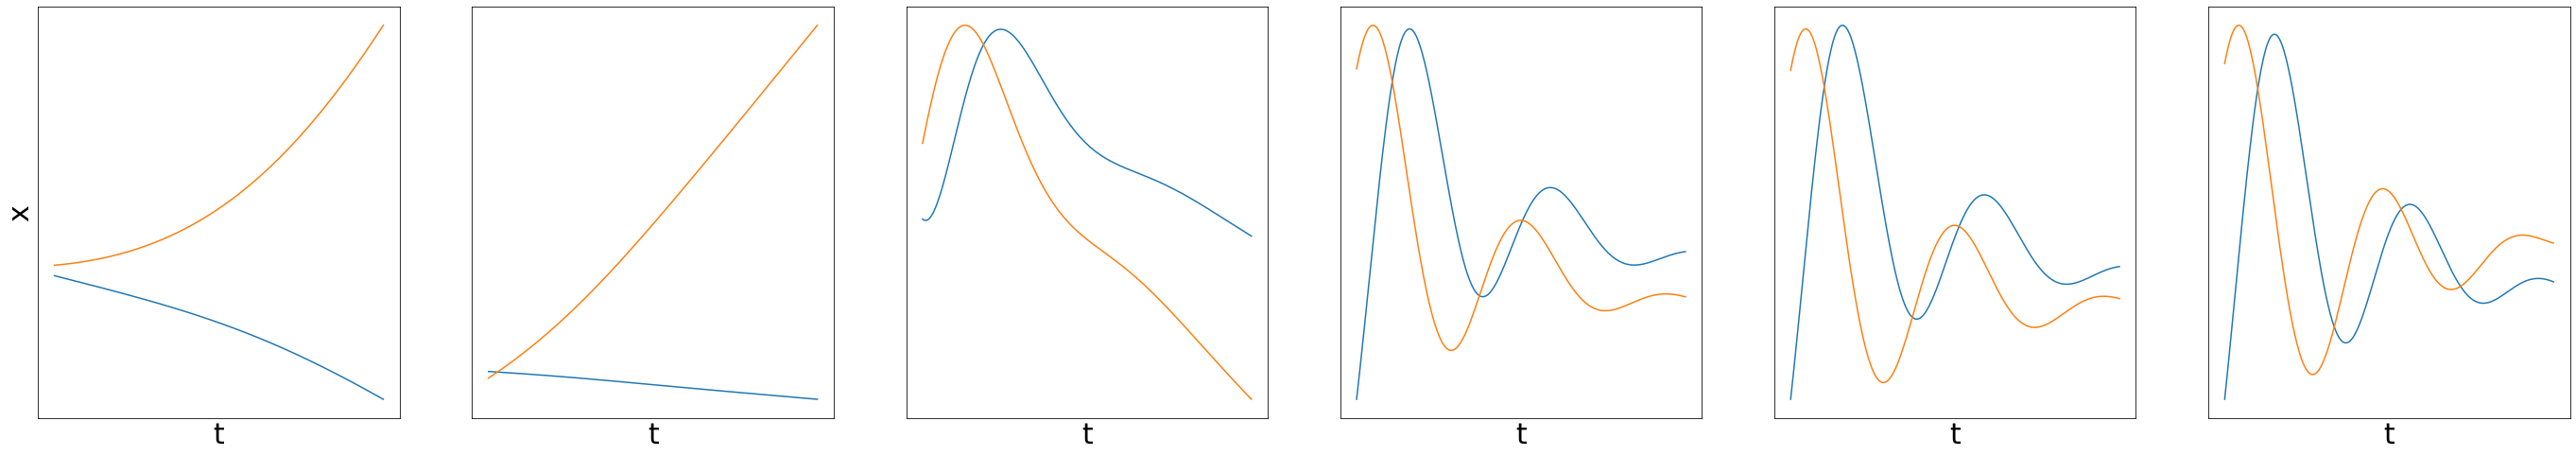

In [7]:
main()